# Exploratory Data Science

Data exploration and understanding the task at hand is a fundamental step in the Machine Learning workflow.
In this notebook, we'll take an opportunity to explore the use case, data and models we'll be using.

We have been tasked with developing an application which can identify objects in static and live images. In this notebook we use a pre-trained machine learning model, and explore how it works on static photos. 

To begin, we install and import a range of python packages:

In [4]:
!pip install onnxruntime
!pip install huggingface_hub


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [50]:
from os import environ

import numpy as np
from onnxruntime import InferenceSession
from PIL import Image, ImageColor, ImageDraw, ImageFont
from huggingface_hub import hf_hub_download

from classes import classes

import json


print('Imported libraries')

Imported libraries


## Import our image

In the next cell we import the image we want to test our model on.

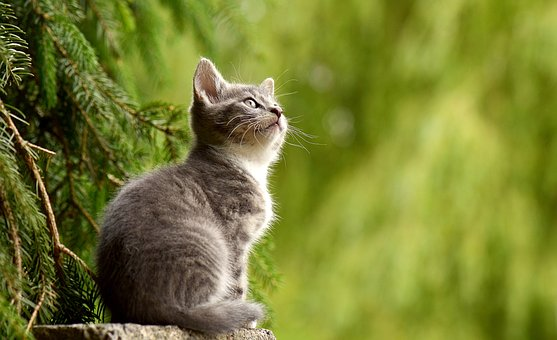

In [6]:
sample_image = 'sample-images/cat.jpg'
sample = Image.open(sample_image)
sample

This image shows a cat. We need to import the image as an array so the ONNX model we will use can process the image.

In [7]:
def transform(image):
    model_image_size = (260, 260)
    boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data


def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw, nh), Image.Resampling.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

In [8]:
converted_image = transform(sample)
converted_image

array([[[[0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608]],

        [[0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608, ..., 0.5019608, 0.5019608,
          0.5019608],
         [0.5019608, 0.5019608, 0.5019608, ..., 0.

## Load in a model

In [9]:
REPO_ID = "dennisjooo/Birds-Classifier-EfficientNetB2"
MODEL_FILENAME = "model.onnx"
CONFIG_FILENAME = "config.json"

In [11]:
model_location = hf_hub_download(repo_id=REPO_ID, filename=MODEL_FILENAME)
config_location = hf_hub_download(repo_id=REPO_ID, filename=CONFIG_FILENAME)

print(f'Downloaded model to {model_location}')
print(f'Downloaded config to {config_location}')

Downloaded model to /opt/app-root/src/.cache/huggingface/hub/models--dennisjooo--Birds-Classifier-EfficientNetB2/snapshots/c77d3335599e71a950d0941c95b8029f6f17c3be/model.onnx.
Downloaded config to /opt/app-root/src/.cache/huggingface/hub/models--dennisjooo--Birds-Classifier-EfficientNetB2/snapshots/c77d3335599e71a950d0941c95b8029f6f17c3be/config.json.


In [56]:
f = open(config_location)
config = json.load(f)

You should be able to see that this file has been added to your file directory on the left hand side of the screen.

Let's now use the model to run object detection on our sample image.

In [59]:
session = InferenceSession(model_location, providers=['CPUExecutionProvider'])
raw_result = session.run(
    [], {'pixel_values': converted_image,}
)
raw_result

[array([[ -4.423528  ,  -6.667912  ,  -9.574208  ,  -7.445978  ,
         -10.160973  ,  -3.643583  , -15.996376  , -11.60469   ,
         -12.895524  ,  -3.7801204 ,   0.4935859 ,  -3.362697  ,
         -13.710708  ,  -6.777451  ,  -8.405229  ,  -6.3329363 ,
          -4.492414  ,  -7.549863  ,  -9.874855  ,  -5.929527  ,
         -13.68696   ,  -8.450126  , -14.091055  ,  -8.627874  ,
          -6.108623  , -10.659281  ,  -8.213182  ,  -9.0813265 ,
         -12.520104  ,  -3.5658302 ,  -5.084721  ,  -9.88817   ,
          -8.177789  , -16.878683  , -13.242211  ,  -4.6288314 ,
         -12.08398   , -10.335475  ,  -6.8571205 ,  -3.7076936 ,
         -13.784088  ,  -3.747415  ,  -5.8096576 ,  -7.1811805 ,
          -1.0872936 ,  -9.020504  , -13.554611  ,  -6.659592  ,
         -13.18596   , -13.635231  ,  -6.7743855 ,  -9.184019  ,
          -8.088824  , -10.364899  ,  -9.80214   ,  -7.182547  ,
         -10.858412  , -15.636268  ,  -4.5672193 , -14.113128  ,
         -15.792213  , -1

In [75]:
def postprocess(raw_result):
    scores, detected_classes = [], []
    for sample in raw_result:
        ind = np.argpartition(sample, -4)[-4:]
        ind = ind[np.argsort(-sample[ind])]
        detected_classes.append([config["id2label"][str(i)] for i in ind])
        scores.append(sample[ind])
    
    return scores, detected_classes

In [76]:
result = postprocess(*raw_result)
result

([array([5.249773 , 4.767049 , 3.615029 , 2.9077373], dtype=float32)],
 [['ZEBRA DOVE', 'JACOBIN PIGEON', 'GREAT ARGUS', 'GO AWAY BIRD']])

The model has returned arrays, each of which holds information about the detected objects. The information includes identifiers for the types of objects, coordinates locating the objects within the image, and detection scores, corresponding to how certain the model is about its prediction.

We can use a few functions to help us to superimpose the information in this dictionary onto the original image.

In [ ]:
def draw_boxes(image, boxes, scores, classes):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    class_colors = {}
    font = ImageFont.load_default()
    image_pil = Image.open(image)

    for index, class_ in enumerate(classes):
        box = boxes[index]
        display_str = f'{class_}: {int(100 * scores[index])}%'
        if class_ not in class_colors:
            class_colors[class_] = colors[hash(class_) * 8 % len(colors)]
        color = class_colors.get(class_)
        _draw_bounding_box_on_image(
            image_pil, box[0], box[1], box[2], box[3], color, font,
            display_str_list=[display_str]
        )
    return image_pil
    image_pil.show()


def _draw_bounding_box_on_image(
        image, ymin, xmin, ymax, xmax, color, font,
        thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    width_scaling_factor = im_width / 416
    height_scaling_factor = im_height / 416
    (left, right, top, bottom) = (
        xmin * width_scaling_factor,
        xmax * width_scaling_factor,
        ymin * height_scaling_factor,
        ymax * height_scaling_factor,
    )
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)], width=thickness, fill=color)

    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        _, _, text_width, text_height = font.getbbox(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin


print('Defined image display functions')

In [ ]:
draw_boxes(sample_image, *result)

Fantastic! So you've seen how we can use a pre-trained model to identify objects in images. In the next notebooks, we will deploy this model using RHODS Model Serving, which allows us to use it as part of a larger application.

## Upload model to S3

In [ ]:
import boto3

s3_endpoint_url = environ.get('AWS_S3_ENDPOINT')
s3_access_key = environ.get('AWS_ACCESS_KEY_ID')
s3_secret_key = environ.get('AWS_SECRET_ACCESS_KEY')

print('Imported s3 library')

In [ ]:
s3_bucket_name = 'model'

In [ ]:
s3 = boto3.client(
    's3', endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key, aws_secret_access_key=s3_secret_key,
)
s3.upload_file(model_location, s3_bucket_name, 'model.onnx')